# Robustness to noise
Compare model with local neighborhood to model without neighborhood.

Predict latent representation of test/val? set by adding different levels of noise to the input (gaussian noise). 

Evaluations:
- Compare how much the latent representation differs from the original one (GT).

Expectation:
- model with neighborhood is more robust to noise

also see fig1_suppl_cluster_subsampling, which does a similar thing, but for subsampling variability. Here, we can choose a random subset of the data to compute noise variability on, we don't need to look at the entire dataset!

In [1]:
from campa.constants import campa_config
from campa.data import MPPData
from campa.tl import Experiment, Predictor
from campa.tl import Cluster
from campa.tl._cluster import add_clustering_to_adata
from campa.pl import annotate_img
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
import os
import numpy as np
import scanpy as sc

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

2022-10-20 16:29:48.943032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 16:30:08.748016: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 16:30:11.270928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 16:30:11.270985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Reading config from /home/icb/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [3]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig1_suppl'
os.makedirs(str(fig_dir), exist_ok=True)

In [4]:
# load models to compare
exp_names = {
    'neigh1': 'VAE_all/CondVAE_pert-CC_noneigh',
    'neigh3': 'VAE_all/CondVAE_pert-CC',
    'neigh5': 'VAE_all/CondVAE_pert-CC_neigh5',
    'neigh7': 'VAE_all/CondVAE_pert-CC_neigh7',
}
preds = {key: Predictor(Experiment.from_dir(name)) for key,name in exp_names.items()}

2022-10-20 16:57:37.452680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-20 16:57:37.498377: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-20 16:57:37.524919: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpusrv05.scidom.de): /proc/driver/nvidia/version does not exist
2022-10-20 16:57:37.904666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# get data to evaluate on
mpp_data = MPPData.from_data_dir(f'{exp_names["neigh7"]}/aggregated/sub-0.001', optional_keys=['mpp', 'latent', 'conditions'], base_dir=campa_config.EXPERIMENT_DIR,
                                data_config="NascentRNA")
s = mpp_data.mpp.shape[1] // 2

## Predict latent with different noise levels
- on subset of data used for clustering

In [5]:
# predict X and noisy X for the two models
scales = np.arange(0,0.2,0.025)
results = []
latents = {}
for scale in scales:
    for name in exp_names.keys():
        exp_name = exp_names[name]
        for seed in [0,1,2,3,4]:
            print(scale, exp_name, seed)
            rng = np.random.default_rng(seed=seed)
            noise = rng.normal(loc=0, scale=scale, size=mpp_data.mpp.shape)
            if name == 'neigh1':
                data = [(mpp_data.mpp+noise)[:,s:s+1,s:s+1,:], mpp_data.conditions]    
            elif name == 'neigh3':
                data = [(mpp_data.mpp+noise)[:,s-1:s+2,s-1:s+2,:], mpp_data.conditions]
            elif name == 'neigh5':
                data = [(mpp_data.mpp+noise)[:,s-2:s+3,s-2:s+3,:], mpp_data.conditions]
            elif name == 'neigh7':
                data = [(mpp_data.mpp+noise)[:,s-3:s+4,s-3:s+4,:], mpp_data.conditions]
            latent_noisy = preds[name].est.model.encoder.predict(data, batch_size=preds[name].batch_size)
            if scale == 0 and latents.get(name, None) is None:
                latents[name] = latent_noisy
            latent = latents[name]
            # calculate mse and mae between latent and latent noisy
            mse = np.sqrt(np.mean((latent - latent_noisy)**2))
            mae = np.mean(np.abs(latent - latent_noisy))
            results.append({'exp_name':exp_name, 'scale': scale, 'seed': seed, 'mse': mse, 'mae': mae})

results = pd.DataFrame(results)
results.to_csv(fig_dir/'noise_robustness.csv')

0.0 VAE_all/CondVAE_pert-CC_noneigh 0
1211/1211 [==============================] - 6s 1ms/step
0.0 VAE_all/CondVAE_pert-CC_noneigh 1
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC_noneigh 2
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC_noneigh 3
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC_noneigh 4
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC 0
1211/1211 [==============================] - 2s 2ms/step
0.0 VAE_all/CondVAE_pert-CC 1
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC 2
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC 3
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC 4
1211/1211 [==============================] - 2s 1ms/step
0.0 VAE_all/CondVAE_pert-CC_neigh5 0
1211/1211 [==============================] - 2s 2ms/s

## Plot results

In [5]:
df = pd.read_csv(os.path.join(fig_dir, 'noise_robustness.csv'), index_col=0)

/tmp/ipykernel_67667/548137146.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC'], x='scale', y='mse', ci=95,
/tmp/ipykernel_67667/548137146.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_noneigh'], x='scale', y='mse',
/tmp/ipykernel_67667/548137146.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_neigh5'], x='scale', y='mse',
/tmp/ipykernel_67667/548137146.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_neigh7'], x='scale', y='mse',


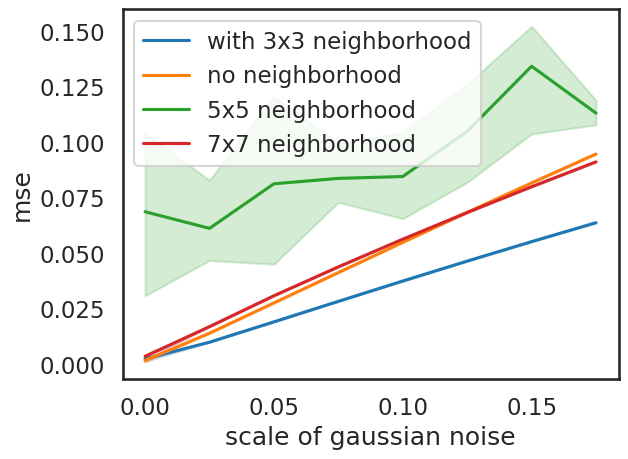

In [6]:
sns.set_style('white')
sns.set_context('talk')

sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC'], x='scale', y='mse', ci=95, 
             label='with 3x3 neighborhood')
g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_noneigh'], x='scale', y='mse', 
                 ci=95, label='no neighborhood')
g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_neigh5'], x='scale', y='mse', 
                 ci=95, label='5x5 neighborhood')
g = sns.lineplot(data=df.loc[df['exp_name']=='VAE_all/CondVAE_pert-CC_neigh7'], x='scale', y='mse', 
                 ci=95, label='7x7 neighborhood')
g.set_xlabel('scale of gaussian noise')
plt.savefig(os.path.join(fig_dir, 'noise_robustness.png'), bbox_inches='tight', dpi=300)

# Plot example cells with all neighborhood models

In [ ]:
# load example data, predict and cluster cells
# wells to select example cells from
data_dirs = {
    'Triptolide (2.5h)': '184A1_triptolide/I10',
    'unperturbed': '184A1_unperturbed/I09',
    'TSA (1h)': '184A1_TSA/I16', 
#    'Meayamycin (12.5h)': '184A1_meayamycin/I12'
}
obj_ids = {
    'Triptolide (2.5h)': [328097, 194924, 328071, 296478, 273257],
    'unperturbed': [347720, 199656, 345913, 306933, 280842],
    'TSA (1h)': [341998, 205243, 341873, 314239, 304075],
}
cluster_name = 'clustering_res0.5'
  
for name, exp_name in exp_names.items():
    cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.001')
    cl = Cluster.from_cluster_data_dir(cluster_data_dir)
    cl.set_cluster_name(cluster_name) 
    example_cells = {}
    print(name)
    for data_name, data_dir in data_dirs.items():
        print(data_dir)
        # load mpp_data
        mpp_data = MPPData.from_data_dir(data_dir, keys=['x', 'y', 'obj_ids', 'mpp'], optional_keys=[], data_config="NascentRNA")
        # prepare for prediction
        pred = preds[name]
        mpp_data.prepare(pred.exp.data_params)
        # predict latent
        # prepare neighborhood
        if pred.exp.data_params["neighborhood"]:
            mpp_data.add_neighborhood(Experiment.from_dir(exp_name).data_params["neighborhood_size"])
        # predict rep   
        mpp_data = pred.predict(mpp_data, reps=['latent'])
        # subset to obj_ids
        mpp_data = mpp_data.subset(obj_ids=obj_ids[data_name], copy=True)
        # project clustering
        mpp_data = cl.project_clustering(mpp_data)
        example_cells[data_name] = mpp_data.get_object_imgs(data=cluster_name, 
                                                      annotation_kwargs={'color':True, 'annotation': cl.cluster_annotation}, 
                                                      img_size=160)
    perts = ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']
    sns.set_context('talk')
    with sns.axes_style('white'):
        fig, axes = plt.subplots(3,3, figsize=(3,3))
        for j, col in enumerate(axes.T):
            for i, ax in enumerate(col):
                ax.imshow(example_cells[perts[i]][j])
                ax.set_yticks([])
                ax.set_xticks([])
                if j == 0:
                    ax.set_ylabel(perts[i], rotation=0, ha='right', va='center', fontsize=10)
        fig.subplots_adjust(wspace=0, hspace=0)
        sns.despine(left=True, bottom=True)
    plt.savefig(fig_dir/f'example_cells_CondVAE_{name}.png', dpi=300, bbox_inches='tight')

Cannot read with memmap:  /home/icb/hannah.spitzer/projects/pelkmans/local_experiments/NascentRNA_new/VAE_all/CondVAE_pert-CC_noneigh/aggregated/sub-0.001/clustering_res0.5.npy
neigh1
184A1_triptolide/I10
46865/46865 [==============================] - 59s 1ms/step
184A1_unperturbed/I09
56393/56393 [==============================] - 68s 1ms/step
184A1_TSA/I16
60258/60258 [==============================] - 73s 1ms/step
neigh3
184A1_triptolide/I10
46865/46865 [==============================] - 62s 1ms/step
184A1_unperturbed/I09


In [ ]:
for name, cur_example_cells in example_cells.items():
    perts = ['unperturbed', 'TSA (1h)', 'Triptolide (2.5h)']
    sns.set_context('talk')
    with sns.axes_style('white'):
        fig, axes = plt.subplots(3,3, figsize=(3,3))
        for j, col in enumerate(axes.T):
            for i, ax in enumerate(col):
                ax.imshow(cur_example_cells[perts[i]][j])
                ax.set_yticks([])
                ax.set_xticks([])
                if j == 0:
                    ax.set_ylabel(perts[i], rotation=0, ha='right', va='center', fontsize=10)
        fig.subplots_adjust(wspace=0, hspace=0)
        sns.despine(left=True, bottom=True)
    plt.savefig(fig_dir/f'example_cells_CondVAE_{name}.png', dpi=300, bbox_inches='tight')